----- Task 1: Q-Network demonstration on a random state -----
Sampled state: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Q-values: tensor([[-0.0428, -0.1753]])
Chosen action: 0

----- Task 2: Training the DQN Agent -----
Episode 50: Total Reward = 23.0
Episode 100: Total Reward = 167.0
Episode 150: Total Reward = 169.0
Episode 200: Total Reward = 97.0
Episode 250: Total Reward = 120.0
Episode 300: Total Reward = 212.0
Episode 350: Total Reward = 375.0
Episode 400: Total Reward = 363.0
Episode 450: Total Reward = 260.0
Episode 500: Total Reward = 370.0
Episode 550: Total Reward = 20.0
Episode 600: Total Reward = 244.0
Episode 650: Total Reward = 123.0
Episode 700: Total Reward = 117.0
Episode 750: Total Reward = 139.0
Episode 800: Total Reward = 150.0
Episode 850: Total Reward = 142.0
Episode 900: Total Reward = 135.0
Episode 950: Total Reward = 131.0
Episode 1000: Total Reward = 37.0


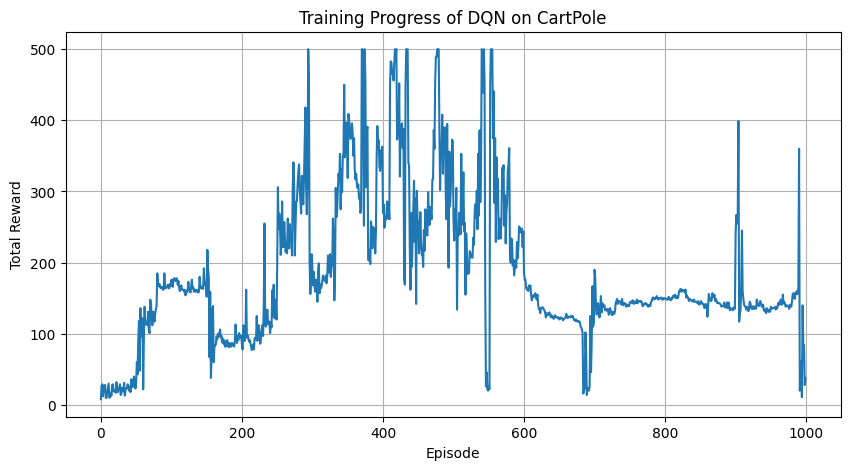


Evaluation over 100 episodes:
Average Reward: 11.0
MoviePy - Building video g:\NTU\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video g:\NTU\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready g:\NTU\SC3000\video\rl-video-episode-0.mp4

----- Task 3: Displaying Recorded Episode Video -----


In [3]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40)  # only show error messages

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# For video display in Jupyter/IPython:
import glob, io, base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# --------------------------------------------------
# Define the Q-Network (Deep Q-Network)
# --------------------------------------------------
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # raw Q-values for each action

# --------------------------------------------------
# Replay Buffer for Experience Replay
# --------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.buffer)

# --------------------------------------------------
# Epsilon-Greedy Action Selection
# --------------------------------------------------
def select_action(state, q_network, epsilon, action_size):
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return int(torch.argmax(q_values).item())

# --------------------------------------------------
# Set Up Environment and Initialization
# --------------------------------------------------
env = gym.make('CartPole-v1', render_mode=None)
state, _ = env.reset(seed=42)
env.action_space.seed(42)
env.observation_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

state_size = env.observation_space.shape[0]  # 4 for CartPole
action_size = env.action_space.n             # 2 actions

# Instantiate Q-network and Target Network
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(capacity=10000)

# --------------------------------------------------
# Task 1: Demonstrate Q-Network on a Random State
# --------------------------------------------------
print("----- Task 1: Q-Network demonstration on a random state -----")
print("Sampled state:", state)
state_tensor = torch.FloatTensor(state).unsqueeze(0)
with torch.no_grad():
    q_vals = q_network(state_tensor)
print("Q-values:", q_vals)
action = int(torch.argmax(q_vals).item())
print("Chosen action:", action)

# --------------------------------------------------
# Task 2: Train the DQN Agent and Evaluate It
# --------------------------------------------------
def train_dqn(env, q_network, target_network, optimizer, replay_buffer,
              num_episodes=1000, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=500):
    episode_rewards = []
    steps_done = 0
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, _ = env.reset(seed=42)
        total_reward = 0
        done = False
        
        while not done:
            # Decay epsilon over time
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, q_network, epsilon, action_size)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones.astype(np.float32))
                
                # Compute current Q-values and target Q-values
                current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    max_next_q = target_network(next_states).max(1)[0]
                target_q = rewards + gamma * max_next_q * (1 - dones)
                
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        episode_rewards.append(total_reward)
        
        # Update target network periodically
        if (episode + 1) % 10 == 0:
            target_network.load_state_dict(q_network.state_dict())
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward}")
    return episode_rewards

print("\n----- Task 2: Training the DQN Agent -----")
training_rewards = train_dqn(env, q_network, target_network, optimizer, replay_buffer,
                             num_episodes=1000)

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN on CartPole")
plt.grid(True)
plt.show()

# Evaluate the trained agent over 100 episodes
def evaluate_dqn(env, q_network, episodes=100):
    q_network.eval()
    eval_rewards = []
    for episode in range(episodes):
        state, _ = env.reset(seed=42)
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_vals = q_network(state_tensor)
            action = int(torch.argmax(q_vals).item())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    return eval_rewards, avg_reward

eval_rewards, avg_reward = evaluate_dqn(env, q_network, episodes=100)
print("\nEvaluation over 100 episodes:")
print("Average Reward:", avg_reward)

# --------------------------------------------------
# Task 3: Record and Display a Video of One Episode
# --------------------------------------------------
# For video recording, create an environment with render_mode set to 'rgb_array'
video_env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                        video_folder='video',
                        episode_trigger=lambda episode_id: True)
state, _ = video_env.reset(seed=42)
done = False
while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_vals = q_network(state_tensor)
    action = int(torch.argmax(q_vals).item())
    state, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated
video_env.close()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video width="400" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4">
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

print("\n----- Task 3: Displaying Recorded Episode Video -----")
show_video()


----- Task 1: Q-Network demonstration on a random state -----
Sampled state: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Q-values: tensor([[-0.0428, -0.1753]])
Chosen action: 0

----- Task 2: Training the DQN Agent for 1000 Episodes -----
Episode 50: Total Reward = 11.0
Episode 100: Total Reward = 12.0
Episode 150: Total Reward = 11.0
Episode 200: Total Reward = 8.0
Episode 250: Total Reward = 10.0
Episode 300: Total Reward = 12.0
Episode 350: Total Reward = 14.0
Episode 400: Total Reward = 12.0
Episode 450: Total Reward = 212.0
Episode 500: Total Reward = 280.0
Episode 550: Total Reward = 365.0
Episode 600: Total Reward = 332.0
Episode 650: Total Reward = 304.0
Episode 700: Total Reward = 303.0
Episode 750: Total Reward = 303.0
Episode 800: Total Reward = 500.0
Episode 850: Total Reward = 500.0
Episode 900: Total Reward = 267.0
Episode 950: Total Reward = 500.0
Episode 1000: Total Reward = 429.0


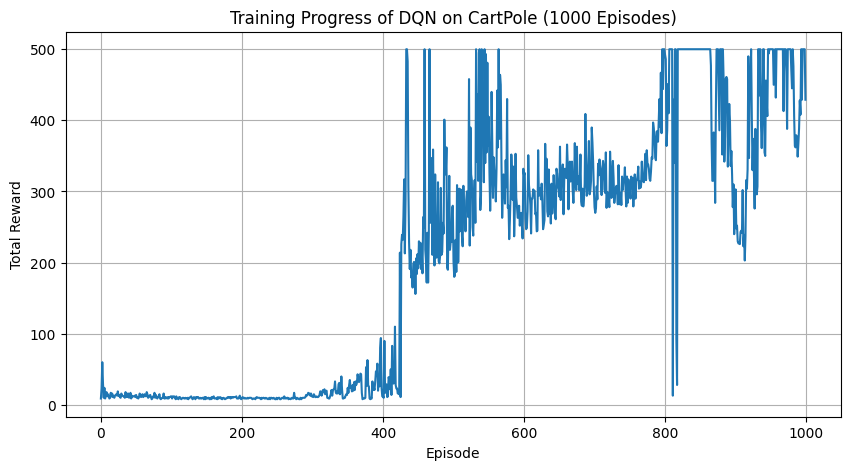


Evaluation over 100 episodes:
Average Reward: 401.6
MoviePy - Building video g:\NTU\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video g:\NTU\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready g:\NTU\SC3000\video\rl-video-episode-0.mp4

----- Task 3: Displaying Recorded Episode Video -----


In [1]:
# cartpole_dqn_full_1000.py

# Workaround for some NumPy versions that lack np.bool8
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40)  # Only show error messages

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# For video display in Jupyter/IPython:
import glob, io, base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# --------------------------------------------------
# Define the Q-Network (Deep Q-Network)
# --------------------------------------------------
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # output raw Q-values for each action

# --------------------------------------------------
# Replay Buffer for Experience Replay
# --------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.buffer)

# --------------------------------------------------
# Epsilon-Greedy Action Selection for DQN
# --------------------------------------------------
def select_action(state, q_network, epsilon, action_size):
    """Return an action according to epsilon-greedy policy."""
    if random.random() < epsilon:
        # Explore
        return random.randrange(action_size)
    else:
        # Exploit (greedy)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return int(torch.argmax(q_values).item())

# --------------------------------------------------
# Environment Setup and Initialization
# --------------------------------------------------
env = gym.make('CartPole-v1', render_mode=None)
# We do not fix the reset seed each episode to allow varied initial conditions
state, _ = env.reset(seed=42)
env.action_space.seed(42)
env.observation_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

state_size = env.observation_space.shape[0]  # 4 for CartPole
action_size = env.action_space.n             # 2 possible actions (left, right)

# Instantiate Q-network and target network
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())  # Initialize target to match Q-network

# Optimizer & Replay Buffer
optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(capacity=10000)

# --------------------------------------------------
# Task 1: Q-Network Demonstration on a Random State
# --------------------------------------------------
print("----- Task 1: Q-Network demonstration on a random state -----")
print("Sampled state:", state)
with torch.no_grad():
    q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
print("Q-values:", q_vals)
chosen_action = int(torch.argmax(q_vals).item())
print("Chosen action:", chosen_action)

# --------------------------------------------------
# Task 2: Train the DQN Agent for 1000 Episodes
# --------------------------------------------------
def train_dqn(env, q_network, target_network, optimizer, replay_buffer,
              num_episodes=1000, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=500,
              target_update_freq=1000):
    """
    Trains the DQN agent for num_episodes. 
    Returns a list of total rewards per episode.
    """
    episode_rewards = []
    steps_done = 0
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, _ = env.reset()  # Varied initial conditions
        total_reward = 0
        done = False
        
        while not done:
            # Decay epsilon over time
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * steps_done / epsilon_decay)
            action = select_action(state, q_network, epsilon, action_size)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1
            
            # Update Q-network if enough samples are available
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones.astype(np.float32))
                
                # Current Q-values
                current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Target Q-values (using the target network)
                with torch.no_grad():
                    max_next_q = target_network(next_states).max(1)[0]
                target_q = rewards + gamma * max_next_q * (1 - dones)
                
                # Compute MSE loss
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Update the target network every target_update_freq steps
            if steps_done % target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
        
        episode_rewards.append(total_reward)
        
        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    return episode_rewards

print("\n----- Task 2: Training the DQN Agent for 1000 Episodes -----")
training_rewards = train_dqn(env, q_network, target_network, optimizer, replay_buffer, 
                             num_episodes=1000)

# Plot the training progress: total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN on CartPole (1000 Episodes)")
plt.grid(True)
plt.show()

# Evaluate the trained agent over 100 episodes (greedy policy)
def evaluate_dqn(env, q_network, episodes=100):
    """
    Runs the agent for 'episodes' times in a greedy fashion (argmax),
    and returns the average total reward.
    """
    q_network.eval()
    eval_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
            action = int(torch.argmax(q_vals).item())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    return eval_rewards, avg_reward

eval_rewards, avg_reward = evaluate_dqn(env, q_network, episodes=100)
print("\nEvaluation over 100 episodes:")
print("Average Reward:", avg_reward)

# --------------------------------------------------
# Task 3: Record and Display a Video of One Episode
# --------------------------------------------------
def show_video():
    """Displays the first MP4 file in the 'video' folder (works in Jupyter/IPython)."""
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video width="400" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4">
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Create a video-recording environment with render_mode='rgb_array'
video_env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                        video_folder='video',
                        episode_trigger=lambda episode_id: True)

state, _ = video_env.reset()
done = False
while not done:
    with torch.no_grad():
        q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
    action = int(torch.argmax(q_vals).item())
    state, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated

video_env.close()  # Finalize and save the video

print("\n----- Task 3: Displaying Recorded Episode Video -----")
show_video()


----- Task 1: Q-Network demonstration on a random state -----
Sampled state: [-0.00354522  0.00073445  0.00024295  0.02160962]
Q-values: tensor([[-0.0399, -0.1791]])
Chosen action: 0

----- Task 2: Training the DQN Agent for 1000 Episodes -----
Episode 50: Total Reward = 13.0
Episode 100: Total Reward = 14.0
Episode 150: Total Reward = 23.0
Episode 200: Total Reward = 212.0
Episode 250: Total Reward = 197.0
Episode 300: Total Reward = 500.0
Episode 350: Total Reward = 256.0
Episode 400: Total Reward = 218.0
Episode 450: Total Reward = 333.0
Episode 500: Total Reward = 434.0
Episode 550: Total Reward = 500.0
Episode 600: Total Reward = 500.0
Episode 650: Total Reward = 500.0
Episode 700: Total Reward = 500.0
Episode 750: Total Reward = 272.0
Episode 800: Total Reward = 500.0
Episode 850: Total Reward = 500.0
Episode 900: Total Reward = 500.0
Episode 950: Total Reward = 500.0
Episode 1000: Total Reward = 500.0


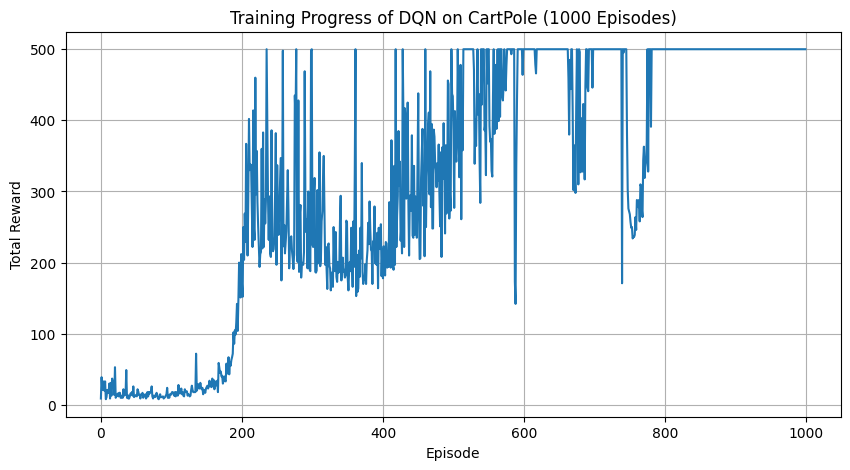


Evaluation over 100 episodes:
Average Reward: 500.0
MoviePy - Building video g:\NTU\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video g:\NTU\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready g:\NTU\SC3000\video\rl-video-episode-0.mp4

----- Task 3: Displaying Recorded Episode Video -----


In [22]:
# cartpole_dqn_improved.py

# Workaround for some NumPy versions that lack np.bool8
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40)  # Only show error messages

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# For video display in Jupyter/IPython:
import glob, io, base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# --------------------------------------------------
# Define the Q-Network (Deep Q-Network)
# --------------------------------------------------
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # output raw Q-values for each action

# --------------------------------------------------
# Replay Buffer for Experience Replay
# --------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.buffer)

# --------------------------------------------------
# Epsilon-Greedy Action Selection for DQN
# --------------------------------------------------
def select_action(state, q_network, epsilon, action_size):
    """Return an action according to an epsilon-greedy policy."""
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return int(torch.argmax(q_values).item())

# --------------------------------------------------
# Environment Setup and Initialization
# --------------------------------------------------
env = gym.make('CartPole-v1', render_mode=None)
state, _ = env.reset()  # Initial state for demonstration
env.action_space.seed(42)
env.observation_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

state_size = env.observation_space.shape[0]  # 4 for CartPole
action_size = env.action_space.n             # 2 possible actions

# Instantiate Q-network and target network
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())

# Optimizer & Replay Buffer
optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(capacity=10000)

# --------------------------------------------------
# Task 1: Q-Network Demonstration on a Random State
# --------------------------------------------------
print("----- Task 1: Q-Network demonstration on a random state -----")
print("Sampled state:", state)
with torch.no_grad():
    q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
print("Q-values:", q_vals)
chosen_action = int(torch.argmax(q_vals).item())
print("Chosen action:", chosen_action)

# --------------------------------------------------
# Task 2: Train the DQN Agent for 1000 Episodes
# --------------------------------------------------
def train_dqn(env, q_network, target_network, optimizer, replay_buffer,
              num_episodes=1000, batch_size=128, gamma=0.99,
              epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=2000,
              target_update_freq=500):
    """
    Trains the DQN agent for num_episodes using a Double DQN update.
    Returns a list of total rewards per episode.
    """
    episode_rewards = []
    steps_done = 0
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, _ = env.reset()  # Varied initial conditions
        total_reward = 0
        done = False
        
        while not done:
            # Decay epsilon (slower decay for longer exploration)
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * steps_done / epsilon_decay)
            action = select_action(state, q_network, epsilon, action_size)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1
            
            # Update Q-network if enough samples are available
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones.astype(np.float32))
                
                # Current Q-values
                current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Double DQN update:
                # 1) Choose best next actions using the online network.
                with torch.no_grad():
                    best_next_actions = q_network(next_states).argmax(dim=1, keepdim=True)
                # 2) Evaluate those actions using the target network.
                with torch.no_grad():
                    next_q = target_network(next_states).gather(1, best_next_actions).squeeze(1)
                target_q = rewards + gamma * next_q * (1 - dones)
                
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Update the target network every target_update_freq steps
            if steps_done % target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
        
        episode_rewards.append(total_reward)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    return episode_rewards

print("\n----- Task 2: Training the DQN Agent for 1000 Episodes -----")
training_rewards = train_dqn(env, q_network, target_network, optimizer, replay_buffer, 
                             num_episodes=1000)

# We don't care about the training graph, so we won't optimize for it.
plt.figure(figsize=(10, 5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN on CartPole (1000 Episodes)")
plt.grid(True)
plt.show()
# Evaluate the trained agent over 100 episodes (greedy policy)
def evaluate_dqn(env, q_network, episodes=100):
    """
    Runs the agent for 'episodes' times in a greedy fashion (argmax) and returns the average total reward.
    """
    q_network.eval()
    eval_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
            action = int(torch.argmax(q_vals).item())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    return eval_rewards, avg_reward

eval_rewards, avg_reward = evaluate_dqn(env, q_network, episodes=100)
print("\nEvaluation over 100 episodes:")
print("Average Reward:", avg_reward)

# --------------------------------------------------
# Task 3: Record and Display a Video of One Episode
# --------------------------------------------------
def show_video():
    """Displays the first MP4 file in the 'video' folder (works in Jupyter/IPython)."""
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video width="400" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4">
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

video_env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                        video_folder='video',
                        episode_trigger=lambda episode_id: True)

state, _ = video_env.reset()
done = False
while not done:
    with torch.no_grad():
        q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
    action = int(torch.argmax(q_vals).item())
    state, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated

video_env.close()
print("\n----- Task 3: Displaying Recorded Episode Video -----")
show_video()
